## Solución Alternativa usando el entorno de Kaggle

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
### Optimizando el modelo RNN

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image

In [3]:
import tensorflow as tf
#detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

#instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1721311528.224999      13 service.cc:145] XLA service 0x5bca28932500 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721311528.225052      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1721311528.225056      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1721311528.225059      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1721311528.225062      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1721311528.225064      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1721311528.225067      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1721311528.225069      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1721311528.225072      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
batch_size = 16 * tpu_strategy.num_replicas_in_sync
print(batch_size)

128


## Paso 1. Lectura del conjunto de datos

In [5]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time

start_time = time.time()

# Set the directory path where your images are located
image_dir = '/kaggle/input/dogs-cats-sep/dogs-vs-cats/train'

# Creando el objeto ImageDataGenerator con normalización
datagen = ImageDataGenerator(rescale=1./255)

# Crear un generador para las imágenes
batch_size = 32
cant_imag = 25000
pix1 = 200
pix2 = 200
rgb = 3
num_samples = round((25000 / batch_size) + 1)  # número total de muestras

generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(200, 200),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['cat', 'dog']
)

# Inicialización de los tensores
X_train2 = np.zeros((cant_imag, pix1, pix2, rgb))
y_train2 = np.zeros((cant_imag, 2))

cont = 0

for x_batch, y_batch in generator:
    start_idx = cont * batch_size
    end_idx = start_idx + x_batch.shape[0]
    
    X_train2[start_idx:end_idx] = x_batch
    y_train2[start_idx:end_idx] = y_batch
    
    cont += 1
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f'imagen: {cont * batch_size}, tiempo transcurrido: {minutes:.0f} minutos y {seconds:.2f} segundos', end='\r')
    
    if cont * batch_size >= cant_imag:
        break
print(' ')
print(X_train2.shape)  # Debería imprimir (25000, 200, 200, 3)
print(y_train2.shape)  # Debería imprimir (25000, 2)



Found 25000 images belonging to 2 classes.
 magen: 25024, tiempo transcurrido: 4 minutos y 14.81 segundos
(25000, 200, 200, 3)
(25000, 2)


## Paso 2. Visualizacion Información de Entrada Corregida a 200x200 Pixeles

### En el siguiente plot se observa como se realizo la clasificacion de las imágenes y como actuó el proceso de lotes (size 32), a propósito muestro cada 32 espacios las fotos para garantizar que no se repita alguna

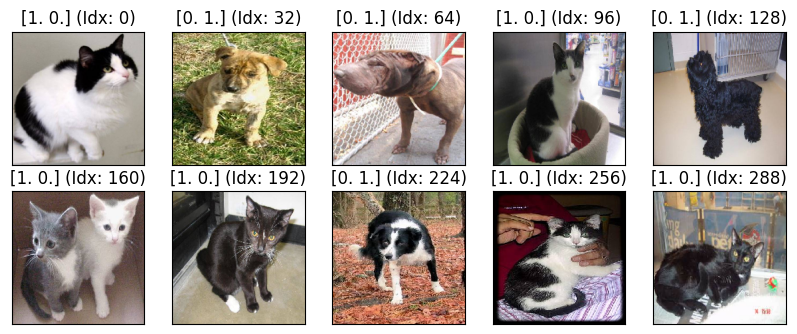

In [17]:
plt.figure(figsize=(10, 10))
j=0
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train2[j])
    plt.title(f"{y_train2[j]} (Idx: {j})")
    plt.xticks([])
    plt.yticks([])
    j+=32
plt.show()

## Paso 3. Construccion Modelo RNA

In [21]:
from tensorflow.keras.optimizers import Adam

with tpu_strategy.scope():

    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(input_shape=(200, 200, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(units=4096, activation="relu"))
    model.add(Dense(units=2, activation="softmax"))
    
    # Compilando el modelo
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    # Entrenando el modelo
    model.fit(X_train2, y_train2, epochs=20, batch_size=128, validation_split=0.2)


Epoch 1/20


2024-07-18 14:36:03.075057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1721313363.532270     753 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e2b6a4ae02078849:0:0), session_name()


  2/157 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.4688 - loss: 0.6953 

I0000 00:00:1721313369.106501     753 tpu_compile_op_common.cc:245] Compilation of e2b6a4ae02078849:0:0 with session name  took 5.574135068s and succeeded
I0000 00:00:1721313369.118164     753 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e2b6a4ae02078849:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14765159999903792924", property.function_library_fingerprint = 17347281589842365536, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,200,200,3,;16,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721313369.118194     753 tpu_compilation_cache_interface.cc:541] After adding entry for ke

156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4887 - loss: 0.6937

I0000 00:00:1721313381.224112     752 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bfc57b33945552b6:0:0), session_name()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4888 - loss: 0.6937

I0000 00:00:1721313389.414511     752 tpu_compile_op_common.cc:245] Compilation of bfc57b33945552b6:0:0 with session name  took 8.19035576s and succeeded
I0000 00:00:1721313389.426071     752 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bfc57b33945552b6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14765159999903792924", property.function_library_fingerprint = 17347281589842365536, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,200,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721313389.426108     752 tpu_compilation_cache_interface.cc:541] After adding entry for key b

157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 229ms/step - accuracy: 0.4888 - loss: 0.6937 - val_accuracy: 0.5072 - val_loss: 0.6930
Epoch 2/20


I0000 00:00:1721313404.923803     790 tpu_compile_op_common.cc:245] Compilation of 2c9dc44ae3a2b0b7:0:0 with session name  took 3.843189537s and succeeded
I0000 00:00:1721313404.926393     790 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2c9dc44ae3a2b0b7:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1947436286706291618", property.function_library_fingerprint = 3570813048341461659, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,200,200,3,;2,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721313404.926419     790 tpu_compilation_cache_interface.cc:541] After adding entry for key 2c

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.5142 - loss: 0.6932 - val_accuracy: 0.4928 - val_loss: 0.6933
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.4995 - loss: 0.6933 - val_accuracy: 0.4928 - val_loss: 0.6935
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.4992 - loss: 0.6934 - val_accuracy: 0.4928 - val_loss: 0.6933
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.5268 - loss: 0.6927 - val_accuracy: 0.4928 - val_loss: 0.6938
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.4877 - loss: 0.6940 - val_accuracy: 0.4928 - val_loss: 0.6933
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.4928 - val_loss: 0.6933
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.5307 - loss: 0.6926 - val_accuracy: 0.4928 - val_loss: 0.6934
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.4738 - loss: 0.6938 - val_accurac

In [22]:
_, accuracy = model.evaluate(X_train2, y_train2)

print(f"Accuracy: {accuracy}")

2024-07-18 14:42:21.538963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1721313741.776228     828 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d378a03ccd96210e:0:0), session_name()


  7/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.5144 - loss: 0.6929

I0000 00:00:1721313745.560976     828 tpu_compile_op_common.cc:245] Compilation of d378a03ccd96210e:0:0 with session name  took 3.784700146s and succeeded
I0000 00:00:1721313745.563372     828 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d378a03ccd96210e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1947436286706291618", property.function_library_fingerprint = 3570813048341461659, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,200,200,3,;4,2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1721313745.563396     828 tpu_compilation_cache_interface.cc:541] After adding entry for key d3

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.5003 - loss: 0.6932
Accuracy: 0.4959999918937683


## Paso 4. Predicción del modelo

### Para hacer algunas predicciones vamos a cargar el conjunto de prueba X_test 

In [65]:
# Set the directory path where your images are located
image_dir_test = '/kaggle/input/dogs-cats-sep/dogs-vs-cats/test'

# Create a list to store the image vectors. Conjunto X_train
X_test = []
im1=0
# Loop through all the images in the directory
for filename_ts in os.listdir(image_dir_test):
    im1+=1
    print(f'imagen: {im1}', end='\r')
    if filename_ts.endswith(".jpg"):
        # Open the image using PIL
        imgts = Image.open(os.path.join(image_dir_test, filename_ts))
        
        # Resize the image to 200x200 pixels (just in case)
        imgts = imgts.resize((200, 200))
        
        # Convert the image to a numpy array
        img_arrayts = np.array(imgts)
        
        # Reshape la imagen en la forma adecuada para el modelo
        img_tensorts = img_arrayts.reshape((200, 200, 3))
        
        # Append the vector to the list
        X_test.append(img_tensorts)

# Convert the list to a numpy array
X_test = np.array(X_test)

print(X_test.shape)  # (12500, 200, 200, 3)

(12500, 200, 200, 3)


In [66]:
X_test = np.divide(X_test, 255.0)

In [69]:
y_pred_proc = model.predict(X_test[0:9])
y_pred = np.argmax(y_pred_proc, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


In [70]:
y_pred

array([1, 1, 1, 1, 0, 0, 1, 1, 1])

In [71]:
# Diccionario de etiquetas personalizadas
labels = {0: 'dog', 1: 'cat'}

# Convertir predicciones a etiquetas personalizadas
y_pred_labels = [labels[pred] for pred in y_pred]

print(y_pred_labels)  # Salida: ['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat']

['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat']


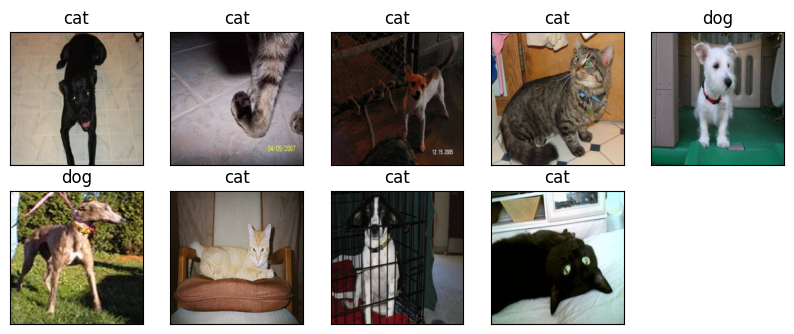

In [72]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(y_pred_labels[i])
    plt.xticks([])
    plt.yticks([])
    j+=32
plt.show()

### Conclusiones

- A pesar que se aumentaron las epochs a 20 y se disminuyo a 0.0001 la tasa de aprendizaje del parámetro Adam, no pudo levantar el accuracy de 0.5.

- En el ejemplo de clasificación para los primeros 9 registros del conjunto de prueba solo se hicieron 6 de forma correcta, es decir, una accuracy de 0.67. Se debe probar con otra arquitectura de red para mejorar el modelo o implementar optimización de hiperparametros con métodos como ModelCheckpoint y EarlyStopping de Keras, combinados con callbacks a fit_generator, pero lamentablemente no cuento con poder de procesamiento para revisar estas técnicas. En kaggle debo dedicar algo de tiempo para configurar adecuadamente los aceleradores gráficos.